In [1]:
import re

import matplotlib.pyplot as pp
import numpy as np

from collections import defaultdict as dd
from datetime import datetime

strptime = datetime.strptime

In [2]:
ds = dd(list)

COLS = 'SIZE LIMIT USED FREE REQ FAIL SLEEP XDOMAIN'.split()

tstamps = set()

pat = re.compile('([^:]+):')

cycle = 0
pgcache = 0
tqz = 0

with open('pdustats.log', mode='rt') as df:
    for dr in df:
        if 'ITEM' in dr or 'buffer arena' in dr:
            cycle += 1
            pgcache = 0
            tqz = 0
            continue
        d = strptime(dr[:15] + ' 2022', '%b %d %H:%M:%S %Y')    
        tstamps.add(d)
        dr = dr[16:]
        elem = pat.match(dr).groups()[0]
        if elem == 'vm pgcache':
            elem = f'vm pgcache_{pgcache}'
            pgcache += 1
        if elem == 'taskq_zone':
            elem = f'taskq_zone_{tqz}'
            tqz += 1

        dr = dr.split(':')[1]
        vals = list(int(x) for x in re.findall('\d+', dr))
        ds[elem].append(vals)
    
tstamps = sorted(tstamps)

for k, v in ds.items():
    ds[k] = np.array(v)
    for cols in 'REQ FAIL SLEEP XDOMAIN'.split():
        CI = COLS.index(cols)
        ds[k][:,CI] = np.diff(ds[k][:,CI], prepend=ds[k][0,CI])

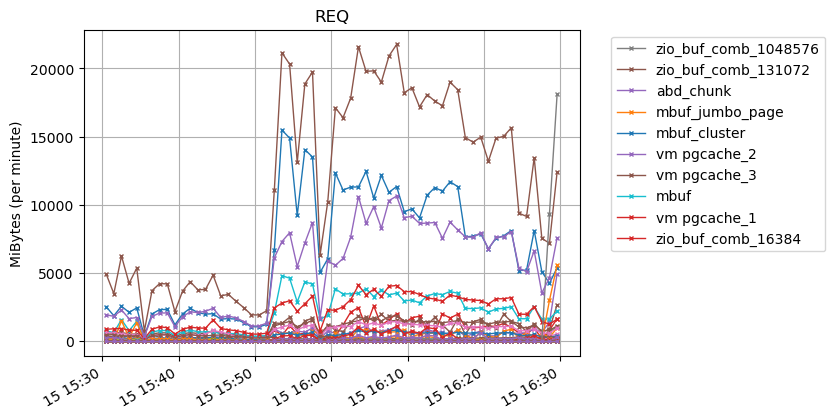

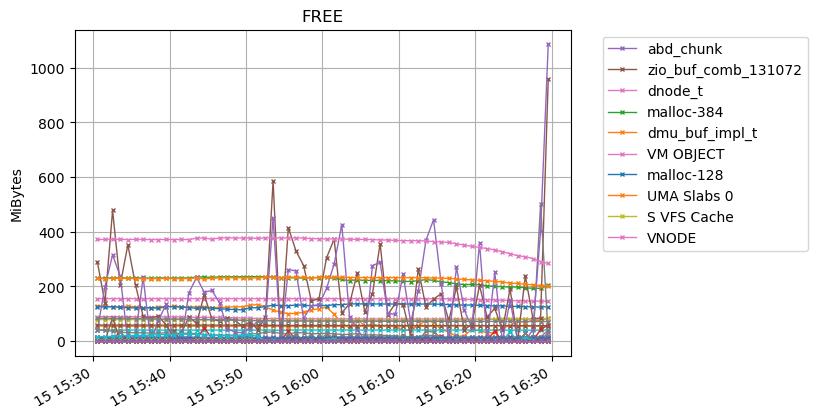

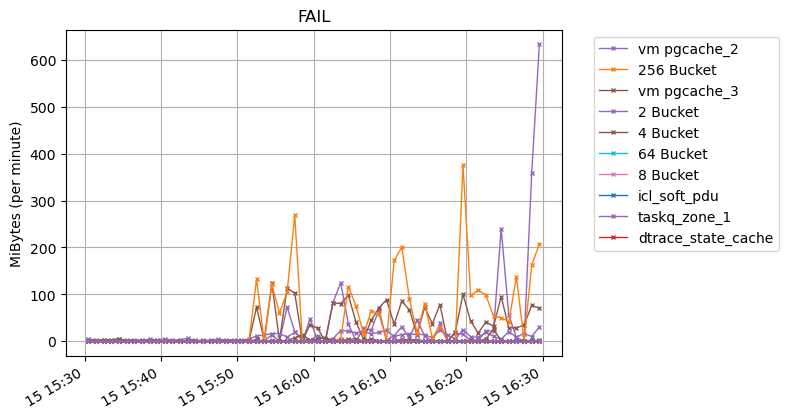

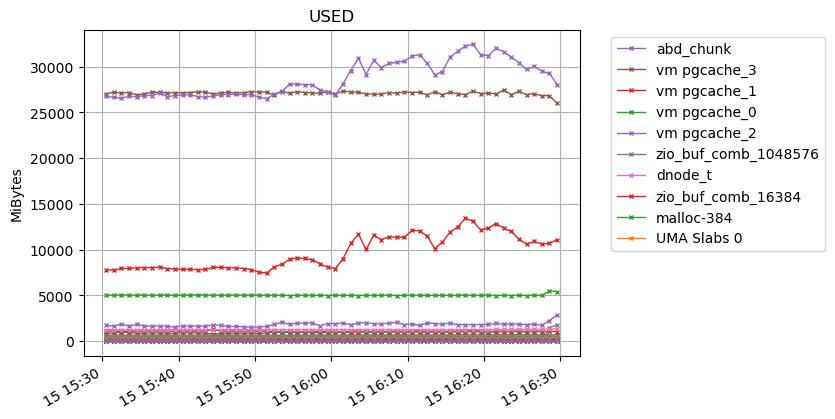

In [3]:
def do_plot(plot_elem, SCALED=2**20, count=90):
    CI = COLS.index(plot_elem)
    CS = COLS.index('SIZE')

    SCALED = 2 ** 20

    peaks = []
    h = []
    n = 0
    for k,v in ds.items():
        if SCALED:
            vals = v[-count:,CI] * v[-count:,CS] / SCALED
        else:
            vals = v[-count:,CI]
        h.append(pp.plot(tstamps[-count:], vals, 'x-', label=k, linewidth=1, markersize=3)[0])
        peaks.append((vals[-1], n))
        pp.title(plot_elem)
        pp.ylabel(('MiBytes' if SCALED else 'Count') + 
                  (' (per minute)' if plot_elem in ('REQ FAIL SLEEP XDOMAIN') else ''))
        n += 1

    label = list(_[1] for _ in sorted(peaks, reverse=True)[:10])  

    pp.legend(handles=list(h[_] for _ in label), bbox_to_anchor=(1.05, 1.0))
    pp.gcf().autofmt_xdate()
    pp.grid(True)
    pp.show()

COUNT=60
do_plot('REQ', count=COUNT)
do_plot('FREE', count=COUNT)
do_plot('FAIL', count=COUNT)
do_plot('USED', count=COUNT)